In [1]:
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip


In [2]:
weights_path = os.path.join("yolov3.weights")
config_path = os.path.join("yolov3.cfg")

net = cv2.dnn.readNetFromDarknet(config_path, weights_path)


In [3]:
names = net.getLayerNames()
print(names)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

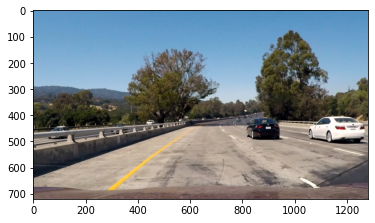

In [4]:
image_path = os.path.join("test_images", "test1.jpg")
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


In [6]:
(H, W) = img.shape[:2]
print(H, W)


720 1280


In [7]:
layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()]

layers_names


['yolo_82', 'yolo_94', 'yolo_106']

In [8]:
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), crop=False, swapRB=False)
net.setInput(blob)
# Calculate run time
start_t = time.time()
layers_output = net.forward(layers_names)
print("A forward pass through yolov3 took {}", format(time.time() - start_t))


A forward pass through yolov3 took {} 0.5320875644683838


In [20]:
layers_output[1].shape


(2028, 85)